In [31]:
import numpy as np
from scipy.stats import norm
import torch
import matplotlib.pyplot as plt

In [49]:
def plot_weight_all(W, title="Matrix", bins=60):
    """
    Plot heatmap, histogram, and eigenspectrum in one figure (1 row, 3 cols).
    Assumes W is square (n x n).
    """
    if isinstance(W, torch.Tensor):
        W = W.detach().cpu().numpy()

    eig = np.linalg.eigvals(W)

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # --- Heatmap ---
    im = axes[0].imshow(
        W,
        aspect="auto",
        origin="upper",
    )
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
    axes[0].set_title(f"{title} Heatmap")

    # --- Histogram ---
    axes[1].hist(W.ravel(), bins=bins)
    axes[1].set_title(f"{title} Histogram")

    # --- Eigenspectrum ---
    radius = np.max(np.abs(eig))
    axes[2].scatter(eig.real, eig.imag, s=10)
    circle = plt.Circle((0, 0), radius, fill=False, linestyle="--")
    axes[2].add_artist(circle)
    axes[2].axhline(0, lw=0.5, color="k")
    axes[2].axvline(0, lw=0.5, color="k")
    axes[2].set_aspect("equal", "box")
    axes[2].set_title(f"{title} eigvals | spectral radius ≈ {radius:.3f}")

    plt.tight_layout()
    plt.show()

In [81]:
def activity_stats(X_mini, threshold=0.5):
    """
    Compute fraction of active vs inactive neurons in an encoding matrix.

    Parameters
    ----------
    X_mini : torch.Tensor or np.ndarray
        Input encoding of shape (1, T, N) or (T, N).
    threshold : float
        Cutoff for considering a neuron "active".

    Returns
    -------
    dict with:
        'frac_active', 'frac_inactive', 'active_inactive_ratio'
    """
    if isinstance(X_mini, torch.Tensor):
        arr = X_mini.detach().cpu().numpy()
    else:
        arr = np.asarray(X_mini)

    # flatten to 1D
    arr = arr.reshape(-1)

    total = arr.size
    active = np.sum(arr >= threshold)
    inactive = total - active

    frac_active = active / total
    frac_inactive = inactive / total
    ratio = active / inactive if inactive > 0 else np.inf

    return {
        "frac_active": frac_active,
        "frac_inactive": frac_inactive,
        "active_inactive_ratio": ratio,
    }

# Bell-shaped input

This code generates a synthetic neural activity input matrix X_mini for training/testing a vanilla RNN (Elman RNN) where each neuron has a time-shifted Gaussian (bell-shaped) activity profile.

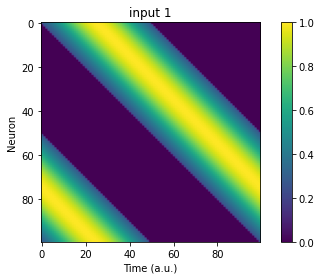

In [ ]:
# Generate input/target ranging from (0,1) for sigmoid nonlinearity (i.e. removed the softmax constrain)
Path = "../data/Ns100_SeqN100/encodings/"

# parameters
N, TotalSteps, T = 100, 2000, 100  # neurons, total time steps, downsampled steps

# initialize input (N x T)
X = np.zeros((np.int64(N), np.int64(TotalSteps)))

# create Gaussian "bump" (bell-shaped curve)
tmp = np.linspace(norm.ppf(0.05), norm.ppf(0.95), np.int64(TotalSteps / 2))
BellShape = norm.pdf(tmp)  # Bellshape vector

# build template activite: half Gaussian bump, half zeros
template = np.concatenate((BellShape, np.zeros(np.int64(TotalSteps / 2))))

# reinitialize X to build the time-shifting matrix
X = np.zeros((np.int64(N), np.int64(TotalSteps)))

# shift the template by a fixed amount to make sequentially activate neurons
for i in np.arange(np.int64(N)):
    X[i, :] = np.roll(template, np.int64(i * (TotalSteps / N)))

# select T evenly spaced time steps out of total number (downsampling)
Select_T = np.arange(0, TotalSteps, np.int64(TotalSteps / T), dtype=int)

# take only the sampled points and transpose so time is the first axis (rows)
tmp = np.expand_dims((X[:, Select_T].T), axis=0)

# normalize inputs
tmp = tmp / tmp.max()

# convert to PyTorch and save
X_mini = torch.tensor(tmp.astype(np.single))
torch.save(
    {"X_mini": X_mini, "Target_mini": X_mini},
    Path + "Ns{}_SeqN{}_asym1.pth.tar".format(N, T),
)

# plot and save plot
plt.figure()
plt.imshow(X_mini[0, :, :].T.numpy())
plt.colorbar()
plt.title("input 1")
plt.ylabel("Neuron")
plt.xlabel("Time (a.u.)")
plt.tight_layout()
plt.savefig(Path + "Ns{}_SeqN{}_asym1.png".format(N, T))
plt.show()

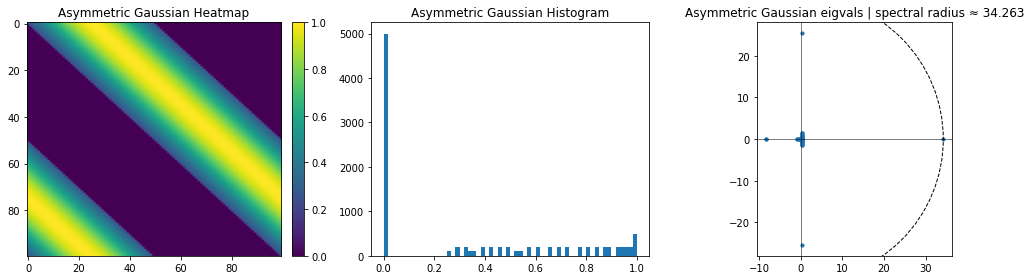

In [83]:
# Grab the square encoding matrix
X_square = X_mini[0].T.numpy()

# Plot with eigenspectrum
plot_weight_all(X_square, title="Asymmetric Gaussian")

In [112]:
# Activity
stats = activity_stats(X_mini, threshold=0.5)
print(stats)

{'frac_active': 0.35, 'frac_inactive': 0.65, 'active_inactive_ratio': 0.5384615384615384}


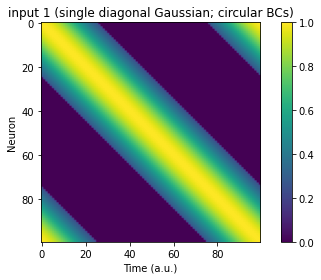

In [ ]:
Path = "../data/Ns100_SeqN100/encodings/"

# parameters
N, TotalSteps, T = 100, 2000, 100  # neurons, total time steps, downsampled steps

# initialize input (N x TotalSteps)
X = np.zeros((np.int64(N), np.int64(TotalSteps)))

# create Gaussian "bump" (bell-shaped curve)
tmp = np.linspace(norm.ppf(0.05), norm.ppf(0.95), np.int64(TotalSteps / 2))
BellShape = norm.pdf(tmp)  # Bell-shape vector

# --- NEW: build template with Gaussian centered in the middle (zeros on both sides)
half_zeros = np.int64((TotalSteps - len(BellShape)) // 2)
template = np.concatenate(
    (
        np.zeros(half_zeros),
        BellShape,
        np.zeros(TotalSteps - len(BellShape) - half_zeros),
    )
)

# --- NEW: align the template's peak to the sampling grid so it hits the main diagonal
stride = int(TotalSteps // T)  # sampling stride (== TotalSteps // N when T == N)
peak_idx = int(np.argmax(template))  # index of Gaussian peak within template
shift_correction = (-peak_idx) % stride  # roll so peak lands on index 0 mod stride
template_aligned = np.roll(template, shift_correction)

# reinitialize X to build the time-shifting matrix (circular boundary via np.roll)
X = np.zeros((np.int64(N), np.int64(TotalSteps)))
for i in np.arange(np.int64(N)):
    X[i, :] = np.roll(template_aligned, np.int64(i * (TotalSteps / N)))

# --- NEW: sample a contiguous circular window so only one diagonal ridge is shown
center_time = 0  # peak aligned to 0 mod stride
start = (center_time - (T // 2) * stride) % TotalSteps
Select_T = (start + np.arange(T) * stride) % TotalSteps
Select_T = Select_T.astype(int)

# take only the sampled points and transpose so time is the first axis (rows)
tmp = np.expand_dims((X[:, Select_T].T), axis=0)

# normalize inputs
tmp = tmp / tmp.max()

# convert to PyTorch and (optionally) save
X_mini = torch.tensor(tmp.astype(np.single))
torch.save(
    {"X_mini": X_mini, "Target_mini": X_mini}, Path + f"Ns{N}_SeqN{T}_sym1.pth.tar"
)

# plot and save plot
plt.figure()
plt.imshow(X_mini[0, :, :].T.numpy(), origin="upper")
plt.colorbar()
plt.title("input 1 (single diagonal Gaussian; circular BCs)")
plt.ylabel("Neuron")
plt.xlabel("Time (a.u.)")
plt.tight_layout()
plt.savefig(Path + f"Ns{N}_SeqN{T}_sym1.png")
plt.show()

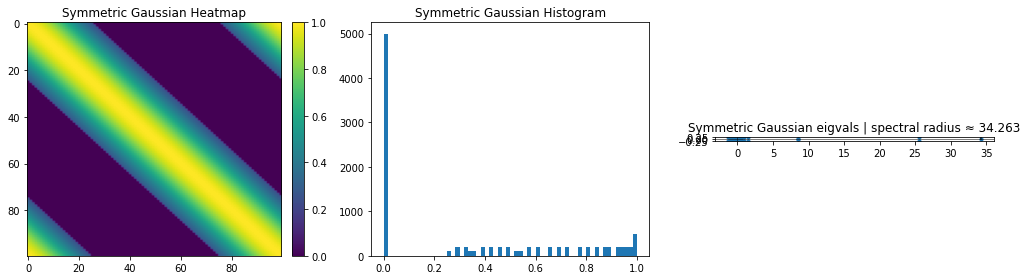

{'frac_active': 0.35, 'frac_inactive': 0.65, 'active_inactive_ratio': 0.5384615384615384}


In [116]:
# Grab the square encoding matrix
X_square = X_mini[0].T.numpy()

# Plot with eigenspectrum
plot_weight_all(X_square, title="Symmetric Gaussian")

# Actvitiy
stats = activity_stats(X_mini, threshold=0.5)
print(stats)

# One-hot encoding

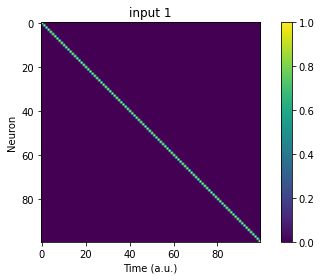

In [ ]:
# parameters
data_path = "../data/Ns100_SeqN100/encodings/"
N, TotalSteps, T = 100, 2000, 100
active = (np.arange(TotalSteps) * N) // TotalSteps
X = np.zeros((N, TotalSteps), dtype=np.float32)
X[active, np.arange(TotalSteps)] = 1.0
Select_T = np.arange(0, TotalSteps, np.int64(TotalSteps / T), dtype=int)
tmp = X[:, Select_T].T[None, :, :]  # (1, T, N)
X_mini = torch.tensor(tmp, dtype=torch.float32)
torch.save(
    {"X_mini": X_mini, "Target_mini": X_mini},
    data_path + "Ns{}_SeqN{}_sym1hot.pth.tar".format(N, T),
)

# plot and save plot
plt.figure()
plt.imshow(X_mini[0, :, :].T.numpy())
plt.colorbar()
plt.title("input 1")
plt.ylabel("Neuron")
plt.xlabel("Time (a.u.)")
plt.tight_layout()
plt.savefig(data_path + "Ns{}_SeqN{}_sym1hot.png".format(N, T))
plt.show()

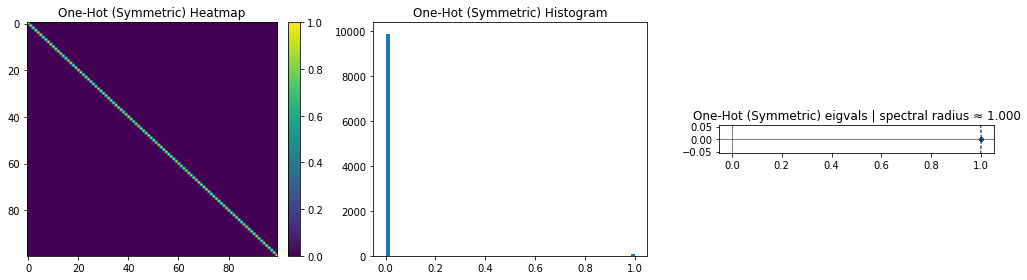

{'frac_active': 0.01, 'frac_inactive': 0.99, 'active_inactive_ratio': 0.010101010101010102}


In [121]:
# Grab the square encoding matrix
X_square = X_mini[0].T.numpy()

# Plot with eigenspectrum
plot_weight_all(X_square, title="One-Hot (Symmetric)")

# Actvitiy
stats = activity_stats(X_mini, threshold=0.5)
print(stats)

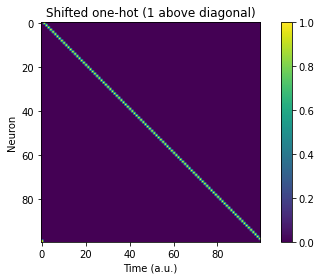

In [ ]:
# parameters
data_path = "../data/Ns100_SeqN100/encodings/"
N, TotalSteps, T = 100, 2000, 100
# assign an "active" neuron index for each time step
active = (np.arange(TotalSteps) * N) // TotalSteps
# shift by +1 (mod N to keep circular boundary conditions)
active_shifted = (active - 1) % N
# build one-hot matrix with shifted diagonal
X = np.zeros((N, TotalSteps), dtype=np.float32)
X[active_shifted, np.arange(TotalSteps)] = 1.0
# downsample
Select_T = np.arange(0, TotalSteps, np.int64(TotalSteps / T), dtype=int)
tmp = X[:, Select_T].T[None, :, :]  # (1, T, N)

# convert to torch
X_mini = torch.tensor(tmp, dtype=torch.float32)

# optionally save
torch.save(
    {"X_mini": X_mini, "Target_mini": X_mini},
    data_path + "Ns{}_SeqN{}_asym1hot.pth.tar".format(N, T),
)

# plot
plt.figure()
plt.imshow(X_mini[0].T.numpy(), origin="upper")
plt.colorbar()
plt.title("Shifted one-hot (1 above diagonal)")
plt.ylabel("Neuron")
plt.xlabel("Time (a.u.)")
plt.tight_layout()
plt.savefig(data_path + "Ns{}_SeqN{}_asym1hot.png".format(N, T))
plt.show()

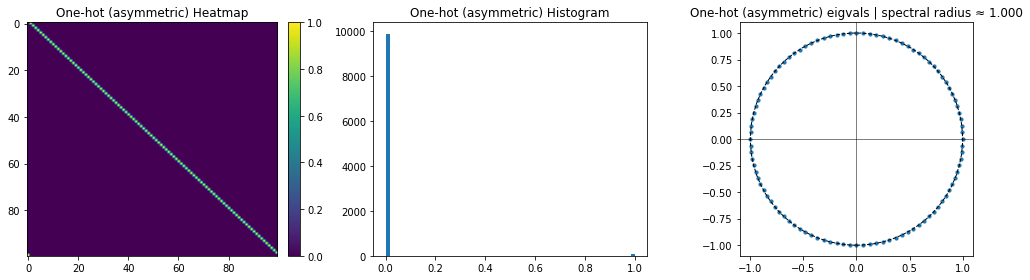

{'frac_active': 0.01, 'frac_inactive': 0.99, 'active_inactive_ratio': 0.010101010101010102}


In [123]:
# Grab the square encoding matrix
X_square = X_mini[0].T.numpy()

# Plot with eigenspectrum
plot_weight_all(X_square, title="One-hot (asymmetric)")

# Actvitiy
stats = activity_stats(X_mini, threshold=0.5)
print(stats)

# k-hot encoding

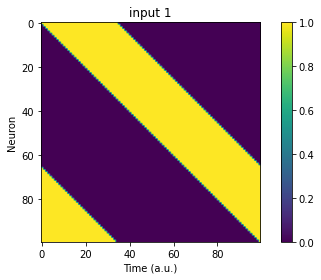

In [ ]:
# parameters
data_path = "../data/Ns100_SeqN100/encodings/"
N, TotalSteps, T = 100, 2000, 100
k = 35  # number of simultaneously active neurons

active = (np.arange(TotalSteps) * N) // TotalSteps
X = np.zeros((N, TotalSteps), dtype=np.float32)

for t in range(TotalSteps):
    idx = active[t]
    # window size of k centered at idx, wrapping circularly
    for offset in range(-(k - 1), 1):
        X[(idx + offset) % N, t] = 1.0

Select_T = np.arange(0, TotalSteps, np.int64(TotalSteps / T), dtype=int)
tmp = X[:, Select_T].T[None, :, :]  # (1, T, N)
X_mini = torch.tensor(tmp, dtype=torch.float32)
torch.save(
    {"X_mini": X_mini, "Target_mini": X_mini},
    data_path + "Ns{}_SeqN{}_asym{}hot.pth.tar".format(N, T, k),
)

# plot and save plot
plt.figure()
plt.imshow(X_mini[0, :, :].T.numpy())
plt.colorbar()
plt.title("input 1")
plt.ylabel("Neuron")
plt.xlabel("Time (a.u.)")
plt.tight_layout()
plt.savefig(data_path + "Ns{}_SeqN{}_asym{}hot.png".format(N, T, k))
plt.show()

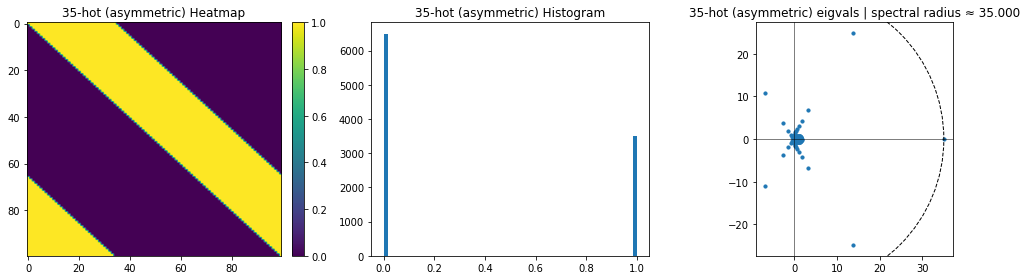

{'frac_active': 0.35, 'frac_inactive': 0.65, 'active_inactive_ratio': 0.5384615384615384}


In [135]:
# Grab the square encoding matrix
X_square = X_mini[0].T.numpy()

# Plot with eigenspectrum
plot_weight_all(X_square, title="35-hot (asymmetric)")

# Actvitiy
stats = activity_stats(X_mini, threshold=0.5)
print(stats)

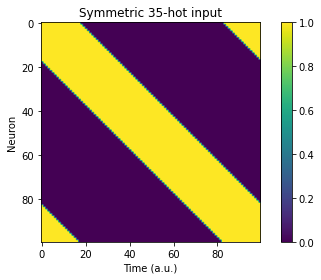

In [ ]:
# parameters
data_path = "../data/Ns100_SeqN100/encodings/"
N, TotalSteps, T = 100, 2000, 100
k = 35  # number of simultaneously active neurons (centered)

active = (np.arange(TotalSteps) * N) // TotalSteps
X = np.zeros((N, TotalSteps), dtype=np.float32)

for t in range(TotalSteps):
    idx = active[t]
    # symmetric window centered at idx, wrapping circularly
    half = k // 2
    for offset in range(-half, half + 1):
        X[(idx + offset) % N, t] = 1.0

Select_T = np.arange(0, TotalSteps, np.int64(TotalSteps / T), dtype=int)
tmp = X[:, Select_T].T[None, :, :]  # (1, T, N)
X_mini = torch.tensor(tmp, dtype=torch.float32)

torch.save(
    {"X_mini": X_mini, "Target_mini": X_mini},
    data_path + "Ns{}_SeqN{}_sym{}hot.pth.tar".format(N, T, k),
)

# plot and save plot
plt.figure()
plt.imshow(X_mini[0, :, :].T.numpy(), origin="upper")
plt.colorbar()
plt.title(f"Symmetric {k}-hot input")
plt.ylabel("Neuron")
plt.xlabel("Time (a.u.)")
plt.tight_layout()
plt.savefig(data_path + "Ns{}_SeqN{}_sym{}hot.png".format(N, T, k))
plt.show()

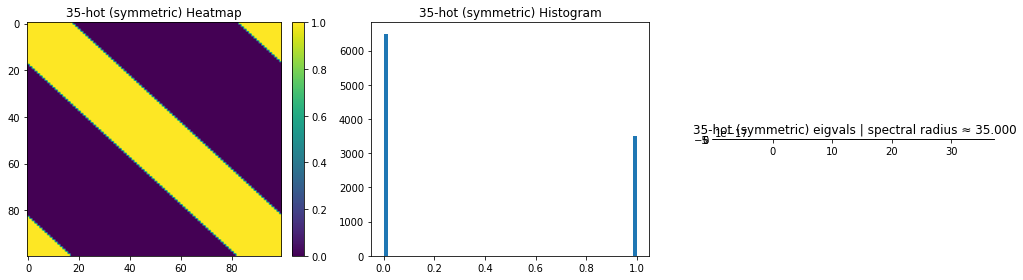

{'frac_active': 0.35, 'frac_inactive': 0.65, 'active_inactive_ratio': 0.5384615384615384}


In [137]:
# Grab the square encoding matrix
X_square = X_mini[0].T.numpy()

# Plot with eigenspectrum
plot_weight_all(X_square, title="35-hot (symmetric)")

# Actvitiy
stats = activity_stats(X_mini, threshold=0.5)
print(stats)

# Small-gaussian

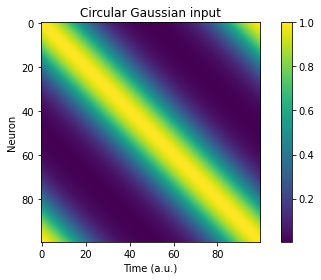

In [141]:
# --- params ---
data_path = "../data/Ns100_SeqN100/encodings/"
N, TotalSteps, T = 100, 2000, 100  # neurons, total steps, downsampled steps

# choose width: either set k (FWHM ~ k) or set sigma directly
k = 35  # try 5–10 for N=100
sigma = k / 2.355  # convert FWHM (k) -> sigma

# optional phase shift to move bump above/below diagonal (negative = above)
shift = 0  # e.g., -2 for a slight upward tilt

# center index over time (uniformly moving around the ring)
centers = ((np.arange(TotalSteps) * N) // TotalSteps + shift) % N  # (TotalSteps,)


def circ_dist(i, j, N):
    d = np.abs(i - j)
    return np.minimum(d, N - d)


# build Gaussian on a ring
X = np.zeros((N, TotalSteps), dtype=np.float32)
idx = np.arange(N)
for t, c in enumerate(centers):
    d = circ_dist(idx, c, N)
    X[:, t] = np.exp(-0.5 * (d / sigma) ** 2)

# normalize each time slice to [0,1] (keeps dynamic range consistent)
X /= X.max(axis=0, keepdims=True)

# downsample to T and convert to (1, T, N) for your model
Select_T = np.arange(0, TotalSteps, TotalSteps // T, dtype=int)
tmp = X[:, Select_T].T[None, :, :]  # (1, T, N)
X_mini = torch.tensor(tmp.astype(np.float32))
torch.save(
    {"X_mini": X_mini, "Target_mini": X_mini},
    data_path + "Ns{}_SeqN{}_sym{}gauss.pth.tar".format(N, T, k),
)

# quick plot
plt.figure()
plt.imshow(X_mini[0].numpy().T)
plt.colorbar()
plt.title("Circular Gaussian input")
plt.ylabel("Neuron")
plt.xlabel("Time (a.u.)")
plt.savefig(data_path + "Ns{}_SeqN{}_sym{}gauss.png".format(N, T, k))
plt.tight_layout()
plt.show()

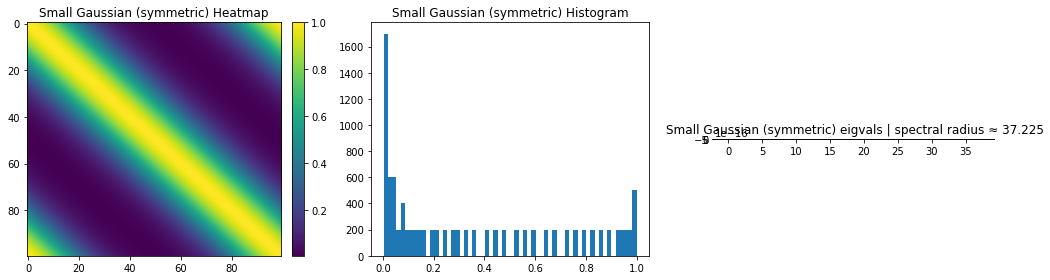

{'frac_active': 0.35, 'frac_inactive': 0.65, 'active_inactive_ratio': 0.5384615384615384}


In [142]:
# Grab the square encoding matrix
X_square = X_mini[0].T.numpy()

# Plot with eigenspectrum
plot_weight_all(X_square, title="Small Gaussian (symmetric)")

# Actvitiy
stats = activity_stats(X_mini, threshold=0.5)
print(stats)

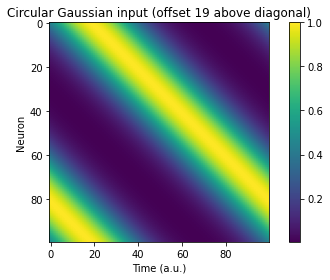

In [150]:
# --- params ---
data_path = "../data/Ns100_SeqN100/encodings/"
N, TotalSteps, T = 100, 2000, 100  # neurons, total steps, downsampled steps

# choose width: either set k (FWHM ~ k) or set sigma directly
k = 35  # try 5–10 for N=100
sigma = k / 2.355  # convert FWHM (k) -> sigma

# how many neurons ABOVE the main diagonal should the peak be?
diag_offset = 19  # e.g., 2 neurons above; use 0 to be on the diagonal

# NOTE: negative shift = above the diagonal
shift = -int(diag_offset)

# center index over time (uniformly moving around the ring)
centers = ((np.arange(TotalSteps) * N) // TotalSteps + shift) % N  # (TotalSteps,)


def circ_dist(i, j, N):
    d = np.abs(i - j)
    return np.minimum(d, N - d)


# build Gaussian on a ring
X = np.zeros((N, TotalSteps), dtype=np.float32)
idx = np.arange(N)
for t, c in enumerate(centers):
    d = circ_dist(idx, int(c), N)  # ensure int index for safety
    X[:, t] = np.exp(-0.5 * (d / sigma) ** 2)

# normalize each time slice to [0,1] (keeps dynamic range consistent)
X /= X.max(axis=0, keepdims=True)

# downsample to T and convert to (1, T, N) for your model
Select_T = np.arange(0, TotalSteps, TotalSteps // T, dtype=int)
tmp = X[:, Select_T].T[None, :, :]  # (1, T, N)
X_mini = torch.tensor(tmp.astype(np.float32))

# save
torch.save(
    {"X_mini": X_mini, "Target_mini": X_mini},
    data_path + "Ns{}_SeqN{}_asym{}gauss.pth.tar".format(N, T, k, diag_offset),
)

# quick plot
plt.figure()
plt.imshow(X_mini[0].numpy().T, origin="upper")
plt.colorbar()
plt.title(f"Circular Gaussian input (offset {diag_offset} above diagonal)")
plt.ylabel("Neuron")
plt.xlabel("Time (a.u.)")
plt.tight_layout()
plt.savefig(data_path + "Ns{}_SeqN{}_asym{}gauss.png".format(N, T, k, diag_offset))
plt.show()

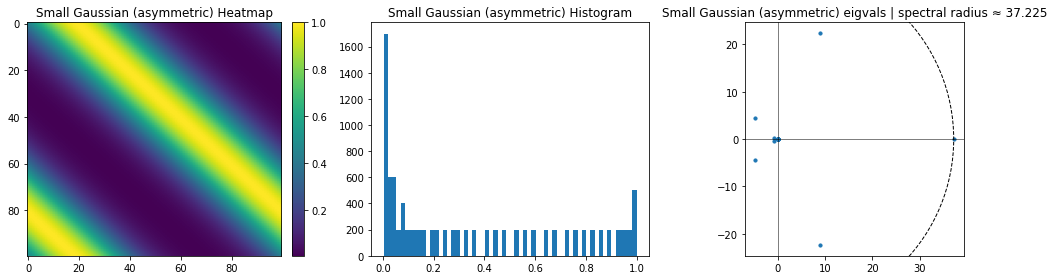

{'frac_active': 0.35, 'frac_inactive': 0.65, 'active_inactive_ratio': 0.5384615384615384}


In [151]:
# Grab the square encoding matrix
X_square = X_mini[0].T.numpy()

# Plot with eigenspectrum
plot_weight_all(X_square, title="Small Gaussian (asymmetric)")

# Actvitiy
stats = activity_stats(X_mini, threshold=0.5)
print(stats)

# Noise

In [ ]:
# Save a noisy version of env 1
# Independent random gaussian noise N~(0,activity*noise_level)
noise_level = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
torch.manual_seed(0)
fig, axes = plt.subplots(1, len(noise_level), figsize=(18, 3))

for i in range(len(noise_level)):
    X_noisy = X_mini + torch.normal(mean=0, std=noise_level[i] * X_mini)
    # torch.save(
    #    {"X_mini": X_noisy, "Target_mini": X_noisy},
    #    Path + "Ns{}_SeqN{}_1_{}per.pth.tar".format(N, T, int(noise_level * 100)),
    # )

    im = axes[i].imshow(X_noisy[0, :, :].T.numpy())
    axes[i].set_title(f"Noise level: {noise_level[i]}")

    # plt.savefig(Path + "Ns{}_SeqN{}_1_{}per.png".format(N, T, int(noise_level * 100)))
fig.colorbar(im, ax=axes, orientation="vertical")
plt.tight_layout()
plt.show()